In [1]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib
import scipy.optimize as sp

In [2]:
## paths to various files

## High damping (dx 1)
#base_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/jiaxiang_data/"
#calib_path = ["20230912/Dx-1/impulse_calibration/D-1",]
#noise_path = ["20230912/Dx-1/noise/D-1",]

## Low damping (dx 0.3)
base_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/jiaxiang_data/"
calib_path = ["20230912/Dx-0.3/impulse_calibration/D-0.3",]
noise_path = ["20230912/Dx-0.3/noise/3",]

In [3]:
## make a list of all the calibration files and sort by impulse size

calib_file_dict = {}
for curr_path in calib_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "**/*.h5"), recursive=True))

    for file in curr_file_list:
        impulse_amp = bu.parse_impulse_amplitude(file)
        if impulse_amp in calib_file_dict.keys():
            calib_file_dict[impulse_amp].append(file)
        else:
            calib_file_dict[impulse_amp] = [file,]

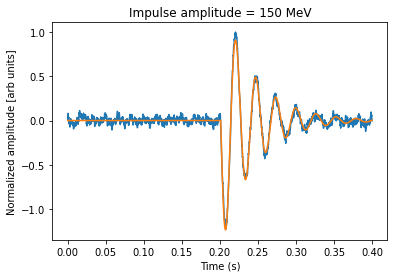

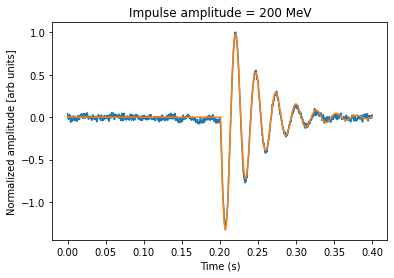

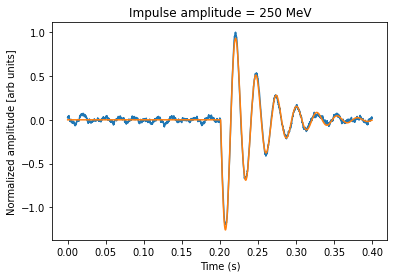

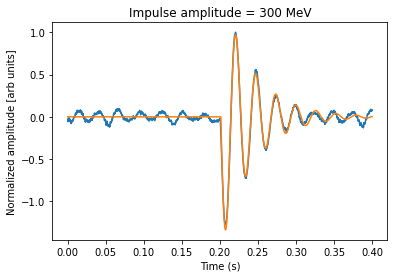

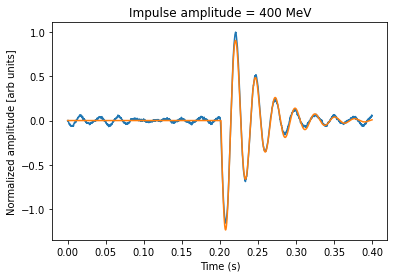

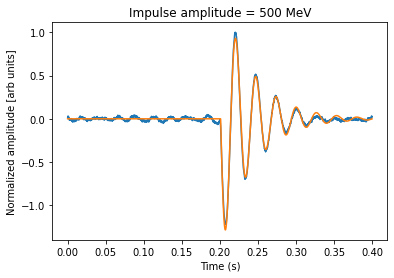

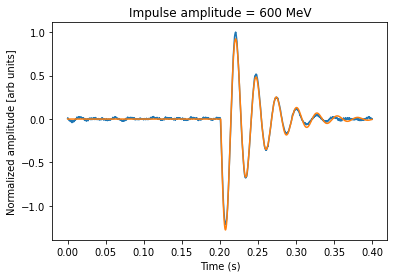

In [5]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
template_dict, template_dict_fit = bu.get_average_template(calib_file_dict, make_plots=True, fit_pars=[-1,2*np.pi*30,10,0.20])

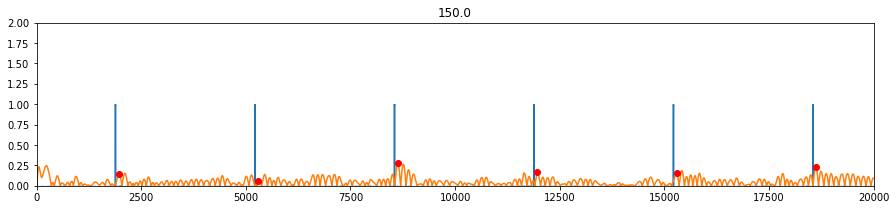

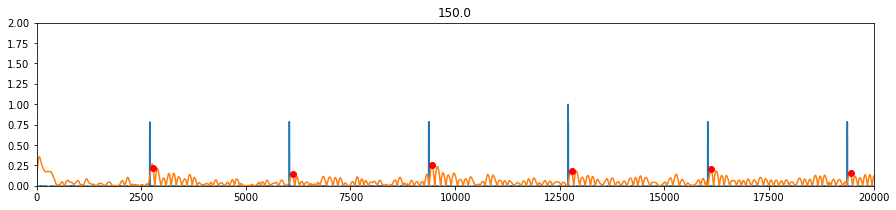

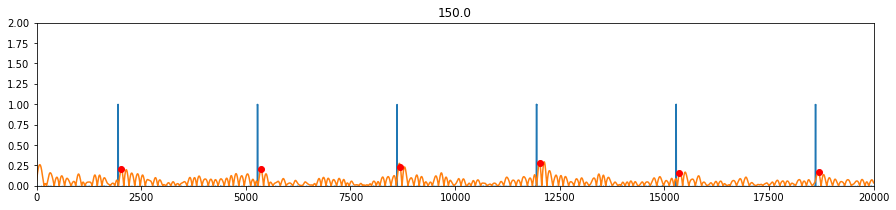

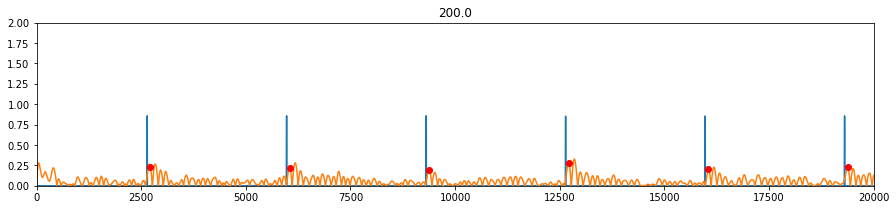

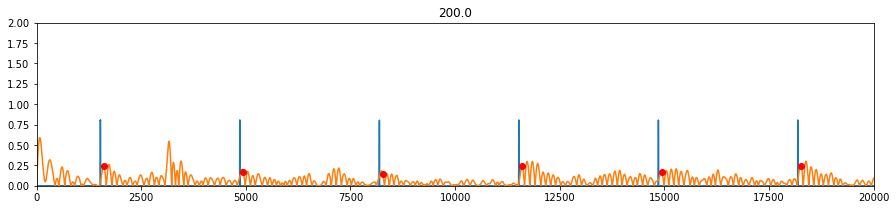

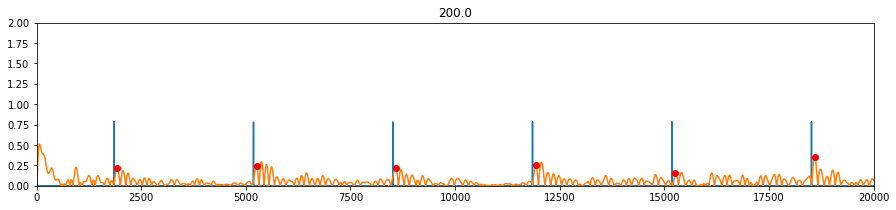

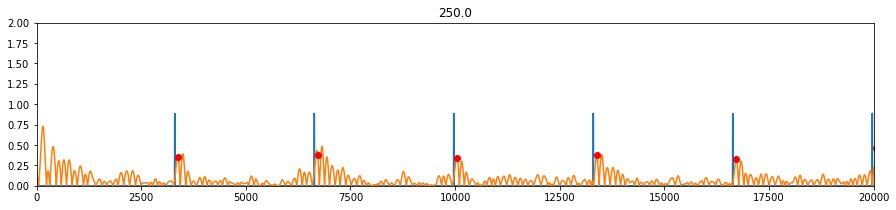

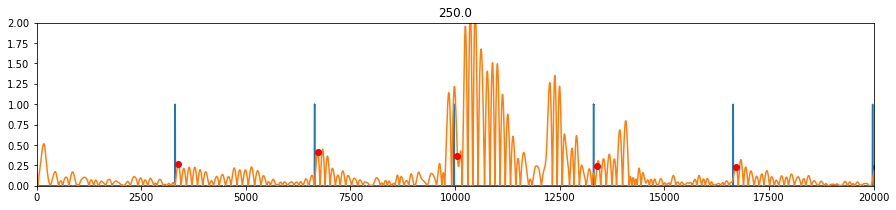

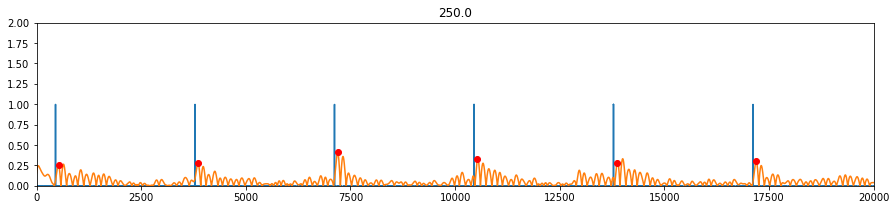

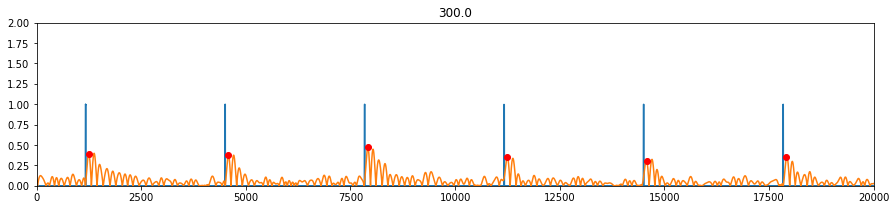

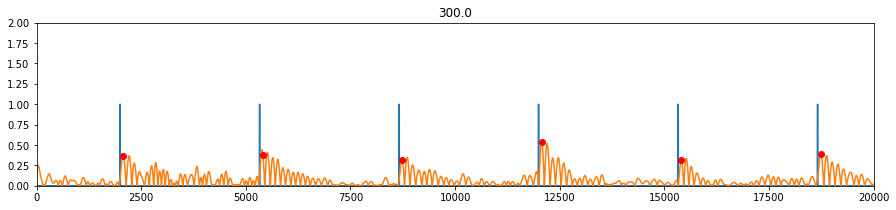

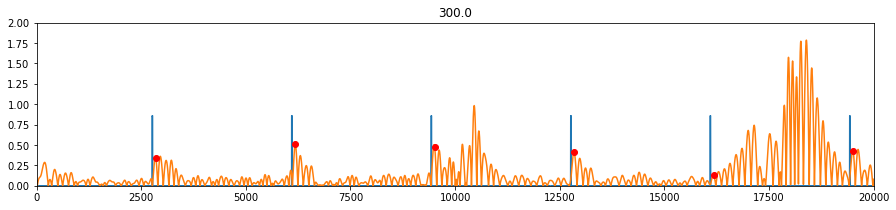

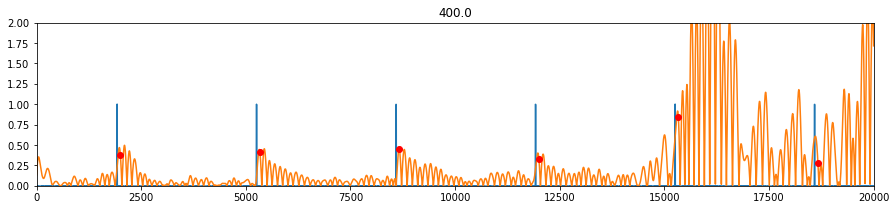

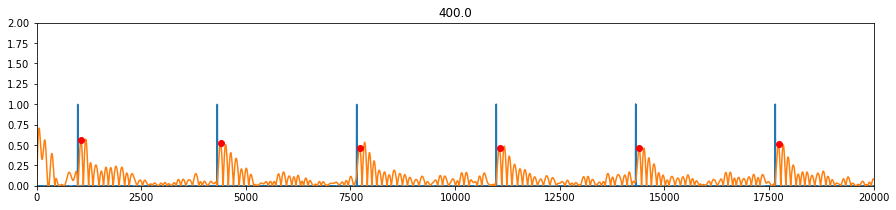

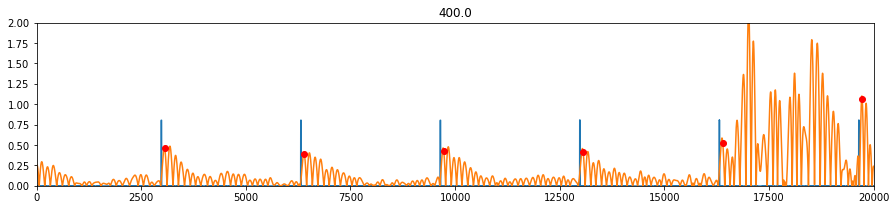

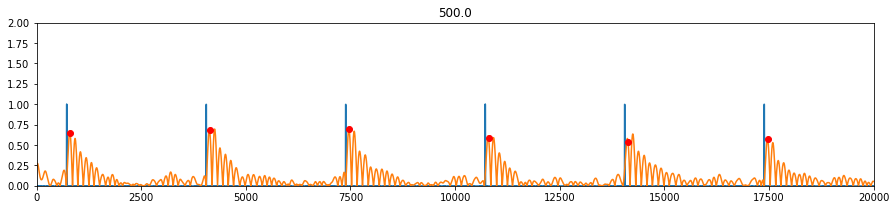

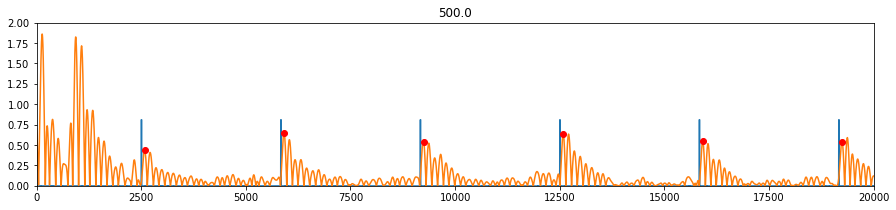

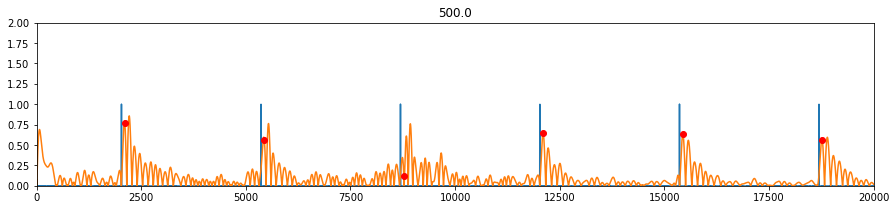

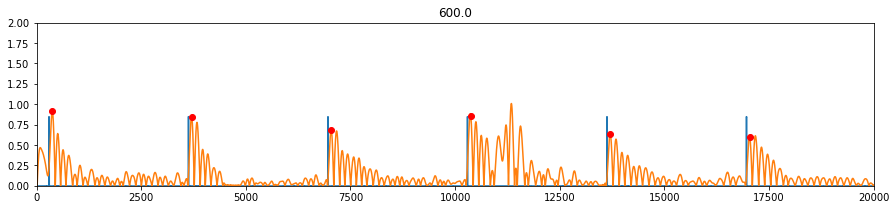

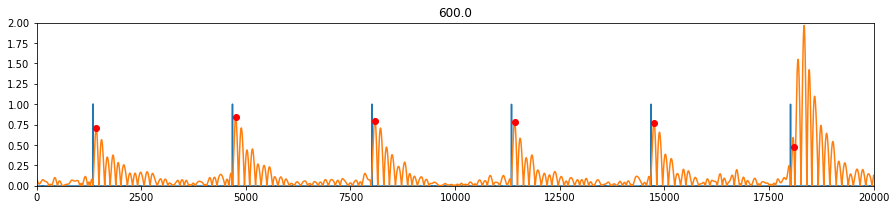

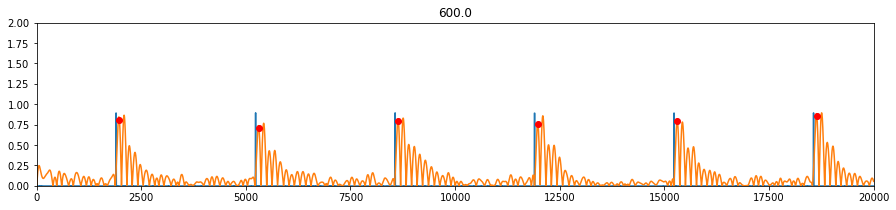

In [50]:
## run a matched filter (assuming white noise on the calibration files)

importlib.reload(bu)
time_corr_amps = bu.correlation_filt(calib_file_dict, template_dict_fit, bandpass=[5,70], notch_list = [], make_plots=True)
## 5, 70, toffset=80, calfac = 8000
bandpass_amps = bu.bandpass_filt(calib_file_dict, template_dict_fit, time_offset=80, bandpass=[5,70], make_plots=False)

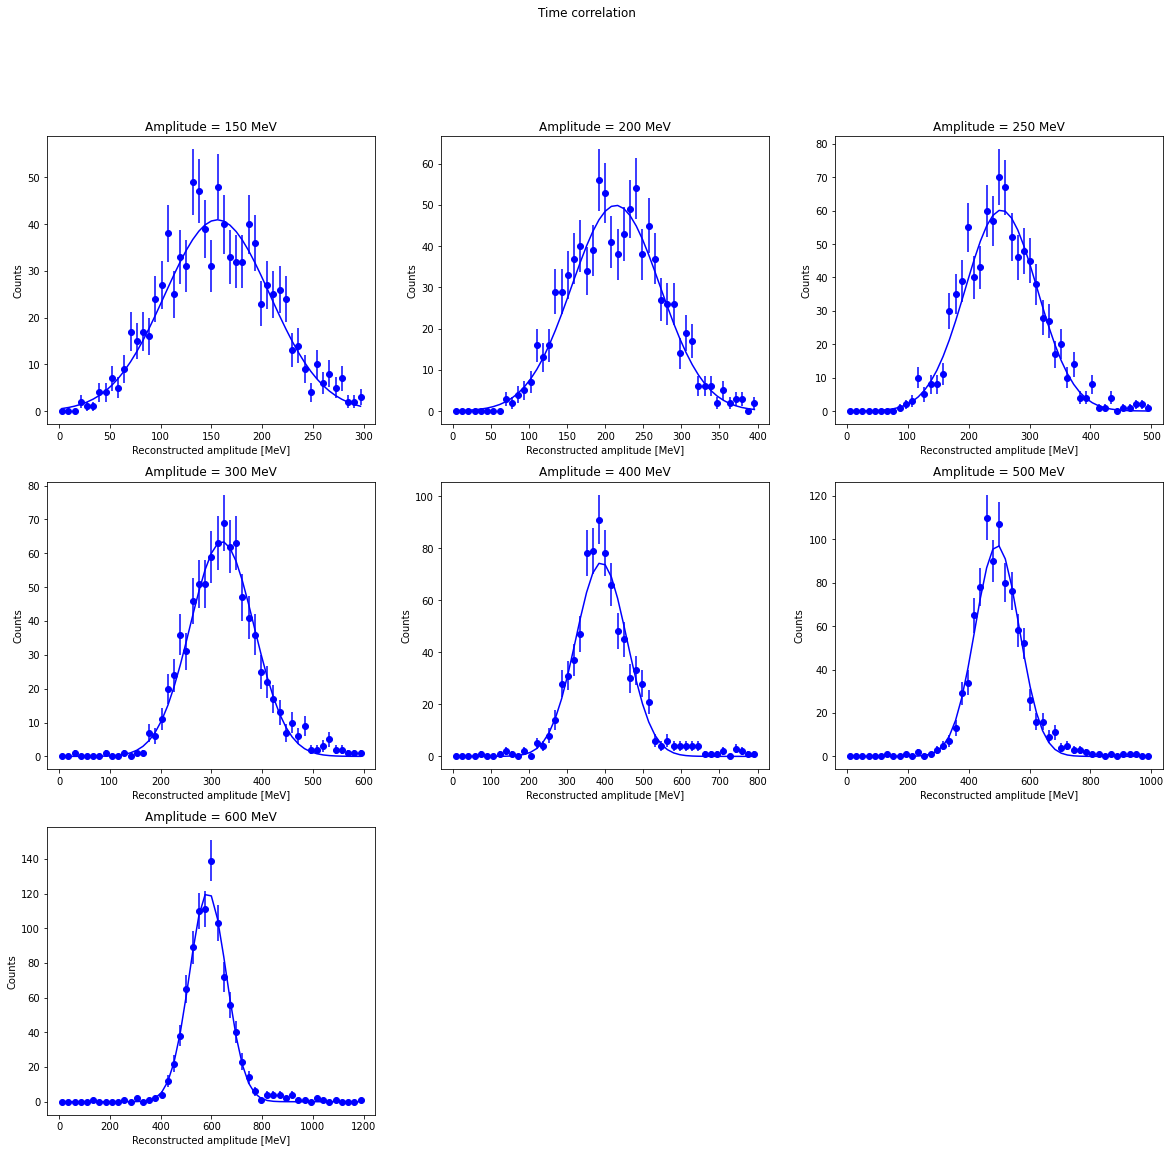

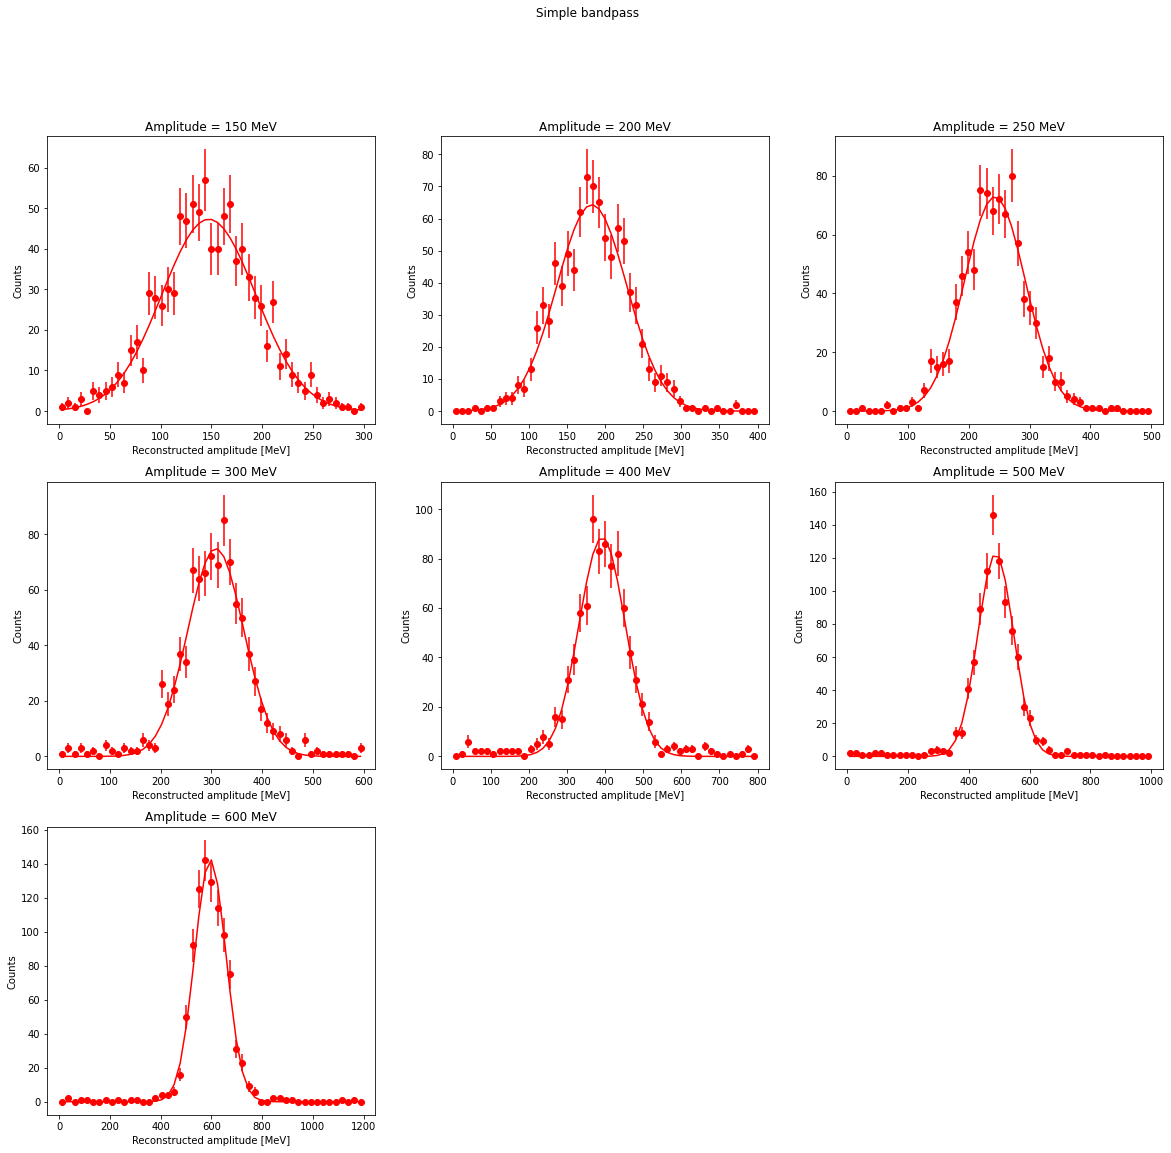

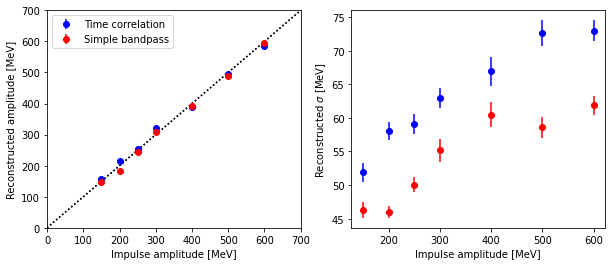

In [51]:
amp_bins = np.arange(0,100,2)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals = []

amp_dicts = [time_corr_amps, bandpass_amps]
amp_methods = ["Time correlation", "Simple bandpass"]
amp_cal_facs = [70, 8000]
amp_colors = ['b', 'r']

for i,filt_amps in enumerate(amp_dicts):
    
    plt.figure(figsize=(20,18))
    for j,amp in enumerate(filt_amps.keys()):
        amp_bins = np.linspace(0,2*amp,50)
        hh,be = np.histogram(filt_amps[amp]*amp_cal_facs[i], bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = sp.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals.append([amp, gp[1], np.sqrt(gcov[1,1]), gp[2], np.sqrt(gcov[2,2]), i])

        plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i], label=amp)
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1fMeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")
        plt.suptitle(amp_methods[i])
        #plt.legend()
    plt.savefig("reconstructed_amplitudes_%s.png"%amp_methods[i], dpi=300)

fit_vals = np.array(fit_vals)

plt.figure(figsize=(10,4))

for i in range(len(amp_methods)):

    gpts = fit_vals[:,-1] == i
    plt.subplot(1,2,1)
    plt.errorbar(fit_vals[gpts,0], fit_vals[gpts,1], yerr=fit_vals[gpts,2], fmt='o', color=amp_colors[i], label=amp_methods[i])
    xmin, xmax = 0, 700
    plt.plot([xmin, xmax], [xmin, xmax], 'k:')
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel("Impulse amplitude [MeV]")
    plt.ylabel("Reconstructed amplitude [MeV]")
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.errorbar(fit_vals[gpts,0], fit_vals[gpts,3], yerr=fit_vals[gpts,4], fmt='o', color=amp_colors[i])
    plt.xlabel("Impulse amplitude [MeV]")
    plt.ylabel("Reconstructed $\sigma$ [MeV]")


plt.savefig("recon_resolution.png", dpi=300)

plt.show()